<a href="https://colab.research.google.com/github/walexi/fellowshipai/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge-labeling Graph Neural Network for one-shot learning

## Notebook Layout <a id='top'></a>
  * [Imports](#imports)
  * [Data](#data)
    * [Loading](#data-loading)
    *[Exploration](#exploration)
  * [Model](#model)
    * [Architecture and Instantiation](#model-architecture-inst)
  * [Training & Evaluation](#training)
  
Please note that this notebook is structured such that each cell is meant to be run in sequence from top to bottom.

# Imports <a id='imports'></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install tensorboardX

     |████████████████████████████████| 225kB 9.7MB/s 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from src.model import EmbeddingImagenet, GraphNetwork, ConvNet
from src.torchtools import *
from src.dataloader import Loader
from src.learner import Learner
import shutil
import os
import random

# Data <a id='data'></a>

## Loading <a id='data-loading'></a>


In [7]:
train_data = datasets.Omniglot(root='./omniglot_data/', download=True, background=True, transform=None)

0it [00:00, ?it/s]

9469952it [00:02, 4444880.60it/s]                             


Extracting downloaded file: ./omniglot_data/omniglot-py/images_background.zip


In [8]:
eval_data = datasets.Omniglot(root='./omniglot_data/', download=True, background=False, transform=None)

0it [00:00, ?it/s]

6463488it [00:01, 3773342.19it/s]                              


Extracting downloaded file: ./omniglot_data/omniglot-py/images_evaluation.zip


## Exploration <a id='exploration'></a>

### Explore the background set

In [7]:
len(eval_data)

13180

In [8]:
len(train_data._alphabets), len(eval_data._characters)

(30, 659)

In [9]:
train_data._alphabets

['Tifinagh',
 'Japanese_(hiragana)',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Mkhedruli_(Georgian)',
 'Syriac_(Estrangelo)',
 'Korean',
 'Sanskrit',
 'Grantha',
 'Balinese',
 'Japanese_(katakana)',
 'Tagalog',
 'Hebrew',
 'Cyrillic',
 'Greek',
 'Bengali',
 'Arcadian',
 'Burmese_(Myanmar)',
 'Malay_(Jawi_-_Arabic)',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'N_Ko',
 'Gujarati',
 'Anglo-Saxon_Futhorc',
 'Futurama',
 'Latin',
 'Early_Aramaic',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Alphabet_of_the_Magi']

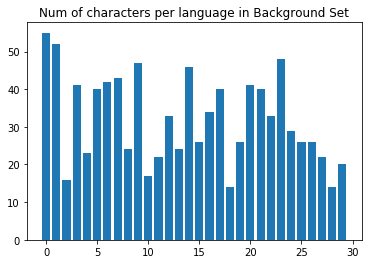

maximum num of characters 55
mean num of characters 32.13
median num of characters 31.0


In [10]:
# background set
per_lang_count = dict()
for a in train_data._alphabets:
    per_lang_count['{}'.format(a)] = len(os.listdir(os.path.join(train_data.target_folder, a)))
plt.bar(range(len(per_lang_count)), list(per_lang_count.values()))
plt.title('Num of characters per language in Background Set')
plt.show()
print('maximum num of characters {}'.format(max(list(per_lang_count.values()))))
print('mean num of characters {:.2f}'.format(np.mean(list(per_lang_count.values()))))
print('median num of characters {}'.format(np.median(list(per_lang_count.values()))))

class: Greek/character08, img shape: (105, 105)


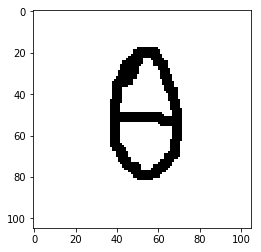

In [11]:
ind = np.random.randint(len(train_data))
img, target = train_data[ind]
class_name = train_data._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

### Explore the evaluation set

In [12]:
len(eval_data)

13180

In [13]:
len(eval_data._alphabets), len(eval_data._characters)

(20, 659)

In [14]:
eval_data._alphabets

['Sylheti',
 'Glagolitic',
 'Oriya',
 'Keble',
 'Atemayar_Qelisayer',
 'Tibetan',
 'Kannada',
 'Manipuri',
 'Ge_ez',
 'Tengwar',
 'Atlantean',
 'Syriac_(Serto)',
 'Mongolian',
 'Malayalam',
 'Gurmukhi',
 'Aurek-Besh',
 'Angelic',
 'ULOG',
 'Avesta',
 'Old_Church_Slavonic_(Cyrillic)']

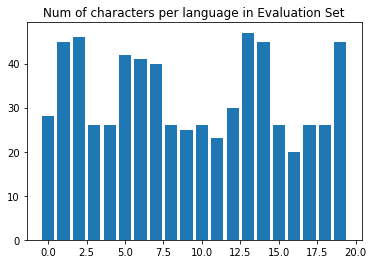

maximum num of characters 47
mean num of characters 32.95
median num of characters 27.0


In [15]:
# evaluation set
eval_per_lang_count = dict()
for a in eval_data._alphabets:
    eval_per_lang_count['{}'.format(a)] = len(os.listdir(os.path.join(eval_data.target_folder, a)))
# num_eval_chars = list(eval_per_lang_count.values())
plt.bar(range(len(eval_per_lang_count)), list(eval_per_lang_count.values()))
plt.title('Num of characters per language in Evaluation Set')
plt.show()
print('maximum num of characters {}'.format(max(list(eval_per_lang_count.values()))))
print('mean num of characters {:.2f}'.format(np.mean(list(eval_per_lang_count.values()))))
print('median num of characters {}'.format(np.median(list(eval_per_lang_count.values()))))

class: Old_Church_Slavonic_(Cyrillic)/character23, img shape: (105, 105)


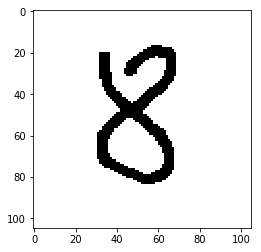

In [16]:
ind = np.random.randint(len(eval_data))
img, target = eval_data[ind]
class_name = eval_data._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

# Model <a id='model'></a>

In [0]:
def set_exp_name():
    exp_name = 'D-{}'.format(tt.arg.dataset)
    exp_name += '_N-{}_K-{}_U-{}'.format(tt.arg.num_ways, tt.arg.num_shots, tt.arg.num_unlabeled)
    exp_name += '_L-{}_B-{}'.format(tt.arg.num_layers, tt.arg.meta_batch_size)
    exp_name += '_T-{}'.format(tt.arg.transductive)
    exp_name += '_SEED-{}'.format(tt.arg.seed)

    return exp_name


## Parameters <a id="parameter"></a>

In [0]:
tt.arg.device = 'cuda:0' if tt.arg.device is None else tt.arg.device
tt.arg.dataset_root = 'omniglot_data/omniglot-py'
tt.arg.num_ways = 20 if tt.arg.num_ways is None else tt.arg.num_ways
tt.arg.num_shots = 1 if tt.arg.num_shots is None else tt.arg.num_shots
tt.arg.num_unlabeled = 0 if tt.arg.num_unlabeled is None else tt.arg.num_unlabeled
tt.arg.num_layers = 3 if tt.arg.num_layers is None else tt.arg.num_layers
tt.arg.meta_batch_size = 10 if tt.arg.meta_batch_size is None else tt.arg.meta_batch_size
tt.arg.transductive = False if tt.arg.transductive is None else tt.arg.transductive
tt.arg.seed = 222 if tt.arg.seed is None else tt.arg.seed
tt.arg.num_gpus = 1 if tt.arg.num_gpus is None else tt.arg.num_gpus

tt.arg.num_ways_train = tt.arg.num_ways
tt.arg.num_ways_test = tt.arg.num_ways

tt.arg.num_shots_train = tt.arg.num_shots
tt.arg.num_shots_test = tt.arg.num_shots

tt.arg.train_transductive = tt.arg.transductive
tt.arg.test_transductive = tt.arg.transductive


### Model Parameters <a id="model_parameter"></a>

Here we set the model parameters such as the number of edge features, node featrues and the size of embedding

In [0]:

tt.arg.num_edge_features = 96
tt.arg.num_node_features = 96
tt.arg.emb_size = 128

### Train/Test Parameters <a id="train_test_parameters"></a>

Here, we set the parameters for training and testing, just enough to test and see that the modified model from the paper works with our dataset

In [0]:
tt.arg.train_iteration = 100
tt.arg.test_iteration = 10
tt.arg.test_interval = 5
tt.arg.test_batch_size = 10
tt.arg.log_step = 1

tt.arg.lr = 1e-3
tt.arg.grad_clip = 5
tt.arg.weight_decay = 1e-6
tt.arg.dec_lr = 15000
tt.arg.dropout = 0.1

In [13]:
tt.arg.experiment = set_exp_name() if tt.arg.experiment is None else tt.arg.experiment
print(set_exp_name())


D-None_N-20_K-1_U-0_L-3_B-10_T-False_SEED-222


In [0]:
np.random.seed(tt.arg.seed)
torch.manual_seed(tt.arg.seed)
torch.cuda.manual_seed_all(tt.arg.seed)
random.seed(tt.arg.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


tt.arg.log_dir_user = tt.arg.log_dir if tt.arg.log_dir_user is None else tt.arg.log_dir_user
tt.arg.log_dir = tt.arg.log_dir_user

if not os.path.exists('asset/checkpoints'):
    os.makedirs('asset/checkpoints')
if not os.path.exists('asset/checkpoints/' + tt.arg.experiment):
    os.makedirs('asset/checkpoints/' + tt.arg.experiment)



Here, we load the training and validation dataset and put them in a dictionary

In [15]:
train_loader = Loader(root=tt.arg.dataset_root, partition='train')
valid_loader = Loader(root=tt.arg.dataset_root, partition='val')

data_loader = {'train': train_loader, 'val': valid_loader}

    


loading alphabet: Burmese_(Myanmar)
Total number of alphabet: 30
Total number of character sets in Burmese_(Myanmar) is 34
Total number of images in Burmese_(Myanmar) is: 680
loading alphabet: Korean
Total number of alphabet: 30
Total number of character sets in Korean is 40
Total number of images in Korean is: 800
loading alphabet: Japanese_(hiragana)
Total number of alphabet: 30
Total number of character sets in Japanese_(hiragana) is 52
Total number of images in Japanese_(hiragana) is: 1040
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
Total number of alphabet: 30
Total number of character sets in Blackfoot_(Canadian_Aboriginal_Syllabics) is 14
Total number of images in Blackfoot_(Canadian_Aboriginal_Syllabics) is: 280
loading alphabet: Malay_(Jawi_-_Arabic)
Total number of alphabet: 30
Total number of character sets in Malay_(Jawi_-_Arabic) is 40
Total number of images in Malay_(Jawi_-_Arabic) is: 800
loading alphabet: Balinese
Total number of alphabet: 30
Total numbe

## Architecture & Initialization <a id="initialization"></a>

Here, we define the encoder network and the graph network.

The encoder network 

In [0]:
enc_module = EmbeddingNetwork(emb_size=tt.arg.emb_size)

gnn_module = GraphNetwork(in_features=tt.arg.emb_size,
                            node_features=tt.arg.num_edge_features,
                            edge_features=tt.arg.num_node_features,
                            num_layers=tt.arg.num_layers,
                            dropout=tt.arg.dropout)


# Training & Evaluation <a id='training'></a>

Let's create a Learner and train our model.

In [19]:
# create trainer
trainer = Learner(enc_module=enc_module,
                         gnn_module=gnn_module,
                         data_loader=data_loader)

trainer.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 step: 1 train/edge_loss: 1.405455 train/edge_accr: 0.550125 train/node_accr: 0.050000 val/edge_loss: 1.386292 val/edge_accr: 0.509500 val/node_accr: 0.060000 val/best_accr: 0.060000
 step: 2 train/edge_loss: 1.365561 train/edge_accr: 0.552125 train/node_accr: 0.075000
 step: 3 train/edge_loss: 1.373965 train/edge_accr: 0.530250 train/node_accr: 0.090000
 step: 4 train/edge_loss: 1.377232 train/edge_accr: 0.524000 train/node_accr: 0.065000
---------------------------
evaluation: total_count=0, accuracy: mean=6.50%, std=0.00%, ci95=0.00%
---------------------------
 step: 5 train/edge_loss: 1.390710 train/edge_accr: 0.504375 train/node_accr: 0.070000 val/edge_loss: 1.386286 val/edge_accr: 0.524000 val/node_accr: 0.065000 val/best_accr: 0.065000
 step: 6 train/edge_loss: 1.378315 train/edge_accr: 0.534125 train/node_accr: 0.095000
 step: 7 train/edge_loss: 1.380848 train/edge_accr: 0.536750 train/node_accr: 0.045000
 step: 8 train/edge_loss: 1.365948 train/edge_accr: 0.552250 train/node_

Training for a longer period seems to improve the model accuracy

In [0]:
tt.arg.train_iteration = 100000 if tt.arg.dataset == 'mini' else 200000
tt.arg.test_iteration = 10000
tt.arg.test_interval = 5000 if tt.arg.test_interval is None else tt.arg.test_interval
tt.arg.test_batch_size = 10
tt.arg.log_step = 1000 if tt.arg.log_step is None else tt.arg.log_step

In [0]:
enc_module = EmbeddingImagenet(emb_size=tt.arg.emb_size)

gnn_module = GraphNetwork(in_features=tt.arg.emb_size,
                            node_features=tt.arg.num_edge_features,
                            edge_features=tt.arg.num_node_features,
                            num_layers=tt.arg.num_layers,
                            dropout=tt.arg.dropout)


In [0]:
# create trainer
trainer = Learner(enc_module=enc_module,
                         gnn_module=gnn_module,
                         data_loader=data_loader)

trainer.train()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 step: 1 train/edge_loss: 1.407240 train/edge_accr: 0.552375 train/node_accr: 0.035000
 step: 2 train/edge_loss: 1.396267 train/edge_accr: 0.571000 train/node_accr: 0.035000
 step: 3 train/edge_loss: 1.403775 train/edge_accr: 0.550875 train/node_accr: 0.055000
 step: 4 train/edge_loss: 1.416085 train/edge_accr: 0.541500 train/node_accr: 0.020000
---------------------------
evaluation: total_count=999, accuracy: mean=10.45%, std=2.05%, ci95=0.13%
---------------------------
 step: 5 train/edge_loss: 1.401651 train/edge_accr: 0.536750 train/node_accr: 0.035000 val/edge_loss: 1.386284 val/edge_accr: 0.573699 val/node_accr: 0.104520 val/best_accr: 0.104520
 step: 6 train/edge_loss: 1.388816 train/edge_accr: 0.508125 train/node_accr: 0.080000
 step: 7 train/edge_loss: 1.394475 train/edge_accr: 0.492375 train/node_accr: 0.060000
 step: 8 train/edge_loss: 1.389594 train/edge_accr: 0.497375 train/node_accr: 0.035000
 step: 9 train/edge_loss: 1.383609 train/edge_accr: 0.527500 train/node_accr: 